# Linear Model

This notebook serves as an example how to use emceeX to fit a linear model to data.

$\Large f\left(x\right) = mx+C$

In [1]:
from emceex import MCMC
import matplotlib.pyplot as plt
import numpy as np

We need to define a model function, where the first argument is the parameter vector $\vec{\theta} = \begin{pmatrix}m\\C\end{pmatrix}$ and the second argument the $x$-coordinate.

In [2]:
def model(theta, x):
    m, C = theta
    return m*x+C

Here we define a vector of the "true" parameter to pick the data from.

In [3]:
theta_true = [3, -2.]

With this vector we create data including Gaussian noise.

In [4]:
N = 10
noise= 1.

x = np.arange(N)
yerr = noise * np.ones(N)
rng = np.random.default_rng()
y = model(theta_true, x) + rng.normal(loc=0., scale=yerr, size=N)

To start the sampling we have to register the parameters and their bounds as a dictionary. We can furthermore specify if we want to sample the parameter logarithmically. `emceeX` assumes an uninformed prior, where the parameters just have to stay within their bounds. The order in which the parameters appear in the dictionary is the order the parameters will have in the $\theta$-vector.

In [5]:
pars = {
    "m": {
        "min": 1.e-1,
        "max": 1.e1,
        "log": True,
    },
    "C": {
        "min": -10.,
        "max": 10.,
        "log": False,
    },
}

We furthermore have to specify the number of walkers we want to use and then we can create the `MCMC` object, which is an `emcee.EnsembleSampler` object with additional functionality. We want to save the state of the sampler in a dump file to be able to resume the run if necessary.

In [6]:
N_walkers = 25
dumpfile = "sampler.dump"

In [7]:
mcmc = MCMC(
    N_walkers,
    pars,
    model,
    x, y, yerr,
    save_to_path=dumpfile,
)

For example it can be used to display some simple plots of the data.

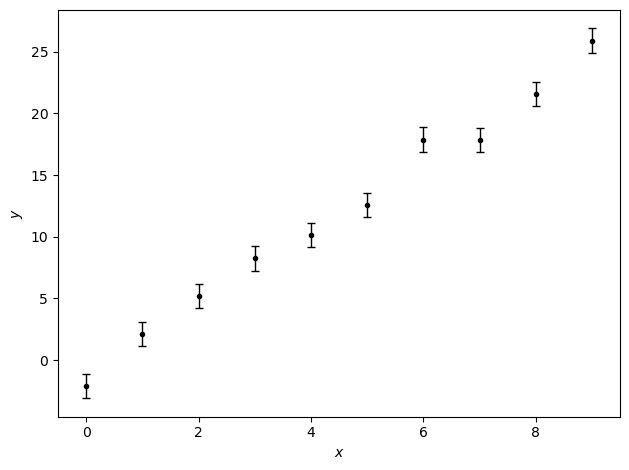

In [8]:
fig, ax = mcmc.plot_data()
ax.set_xlim(x.min()-0.5, x.max()+0.5)
fig.tight_layout()

We can now run the model. For this we have to define the number of steps we want to take. Additionaly we can specify two parameters to monitor convergence: the chain has to be longer that $\beta$ times the mean autocorrelation time and the maximum relative change of the mean autocorrelation time is given by $\delta$. Convergence is evaluated every `interval` steps. The sampler automatically stops, when both criteria are fulfilled. The dump file is written every `interval` steps.

In [9]:
N_steps = 10_000
beta = 50.
delta = 1.e-2
interval = 100

In [10]:
mcmc.run_mcmc(
    N_steps,
    beta=beta,
    delta=delta,
    interval=interval,
)

beta: N/A | delta : N/A:   0%|          | 0/10000 [00:00<?, ?it/s]

The $\beta$ and $\delta$ values in the progress bar are normalized. Convergence is reached, when both displayed parameters are smaller than unity.

We can now plot the walkers to confirm that they have converged to a value.

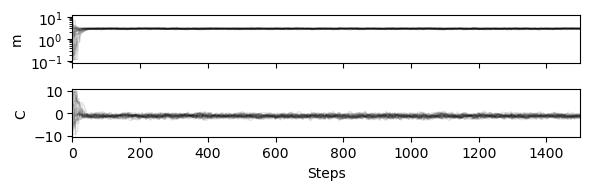

In [11]:
mcmc.plot_walkers();

We can plot the data again and overlay some randomly picked samples, as well as the median value of the parameter vector and the true paramter set.

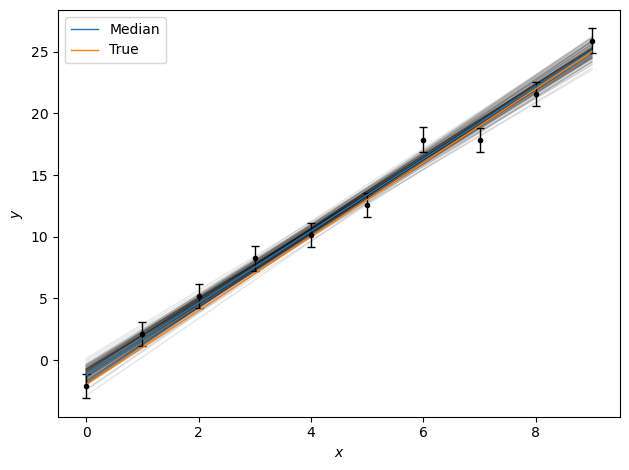

In [12]:
fig, ax = mcmc.plot_data(N_samples=100, theta=[mcmc.get_theta(which="median"), theta_true], theta_labels=["Median", "True"])
ax.set_xlim(x.min()-0.5, x.max()+0.5)
fig.tight_layout()

Furthermore, we can display the scatterplot matrix of the parameters. 

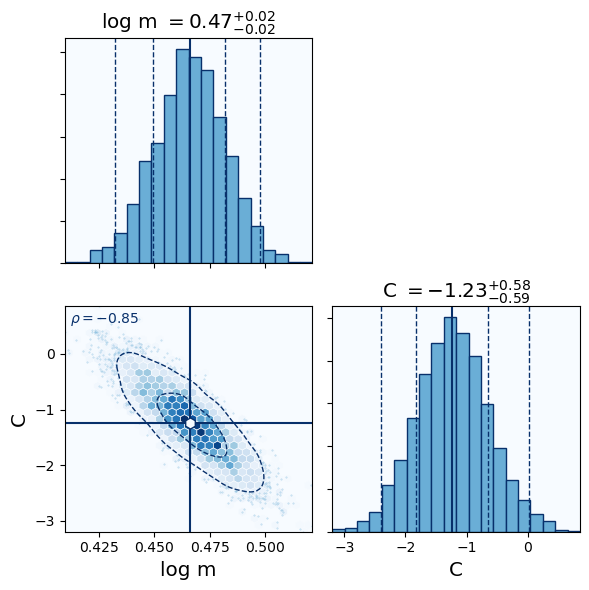

In [13]:
mcmc.plot_pairs(
    sigma_levels=[1., 2.],
    scatter_outside_sigma=2.,
    title_quantiles=[16., 50., 84.],
    show_correlations=True,
);

We can restart a run from a dump file and can change the convergence criteria.

In [14]:
mcmc = MCMC.load_dump(dumpfile)

In [15]:
beta = 100

In [16]:
mcmc.run_mcmc(
    N_steps,
    beta=beta,
    delta=delta,
    interval=interval,
)

beta: N/A | delta : N/A:  13%|#3        | 1500/11500 [00:00<?, ?it/s]

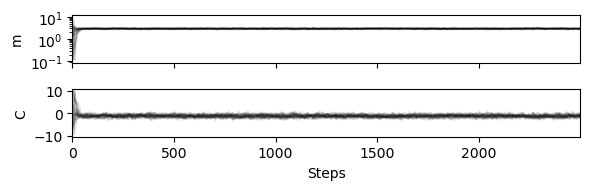

In [17]:
mcmc.plot_walkers();